In [34]:
import time
time.strftime('%c', time.localtime(time.time()))

'Sat Jun 13 02:36:34 2020'

In [35]:
import numpy as np
OUTPUT_DIM = 1000

# Image 로드 & 특징 추출 - J

In [69]:
from os import listdir
from pickle import dump    # pkl 작성을 위함
from tensorflow.keras.applications.vgg16 import VGG16 # VGG => 이후 필요 없음
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input # custom model input에 맞는거 찾기
from tensorflow.keras.layers import Input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, UpSampling2D, Flatten

# 폴더 내의 각 사진으로부터 특징 추출
def extract_features(directory):
   # load the model
   #in_layer = Input(shape=(224, 224, 3))  # input 형태
    
   #model = VGG16(include_top=False, input_tensor=in_layer) # CNN으로!
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1000, activation='softmax'))

    print(model.summary())
   #model = VGG16()
   #model.layers.pop()
   #model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
   #print(model.summary())
    
   # 각 사진마다 특징 추출
    features = dict() # 특징을 저장하기 위한 새 dictionary 생성
    for name in listdir(directory): # name은 directory 안에 있는 image 이름
        # load Image
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image) # numpy array로 변환
        
        image = np.expand_dims(image, axis=0)
        #image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # VGG model을 위한 전처리
        #image = preprocess_input(image)
        
        # 특징 추출
        feature = model.predict(image, verbose=0)
        feature = np.reshape(feature, OUTPUT_DIM )
        
        # image id 얻기
        image_id = name.split('.')[0]
        # 특징 저장
        features[image_id] = feature
        #print('>%s' % name)
    return features

In [4]:
# extract features from all images
directory = 'Flicker8k_Dataset'
print('이미지 수 : %d' % len(listdir(directory)))

features = extract_features(directory)
print('추출된 특징 수 : %d' % len(features))

이미지 수 : 8091
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56,

KeyboardInterrupt: 

In [ ]:
# 추출된 특징을 pkl 파일로 저장
dump(features, open('features2.pkl', 'wb'))

# Description Load

In [36]:
import string
import glob
import os
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM 
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

# 파일 불러오는 함수
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# 이미지에 대한 설명 추출
def load_descriptions(doc):
    mapping = dict() # 사전형
    for line in doc.split('\n'): # \n으로 문장 구분.
        tokens = line.split()
        if len(line) < 2:
            continue
        # 첫 번째 토큰을 이미지id로, 나머지는 설명으로 
        image_id, image_desc = tokens[0], tokens[1:]
        # 이미지 id에서 파일 이름 제거
        image_id = image_id.split('.')[0]
        # 설명 토큰을 문자열로 다시 변환
        image_desc = ' '.join(image_desc)
        # 필요한 경우 리스트 생성
        if image_id not in mapping:
            mapping[image_id] = list()
        # 설명 저장
        mapping[image_id].append(image_desc)
    return mapping

# 설명을 깔끔하게 만들기 위한 함수
def clean_descriptions(descriptions):
    # 구두점 제거를 위한 문자변환표 준비
    table = str.maketrans('', '', string.punctuation) # str.maketrans('원래 문자', '대입할 문자', '제외할 문자')
                                                        # 원래 문자와 대입할 문자의 길이는 같아야한다.
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # 토큰화
            desc = desc.split()
            # 소문자 변환
            desc = [word.lower() for word in desc]
            # 구두점 제거
            desc = [w.translate(table) for w in desc]
            # 두 글자 이상만 남긴다.
            desc = [word for word in desc if len(word)>1]
            # 알파벳이 아닌것 제거
            desc = [word for word in desc if word.isalpha()]
            # 문자열로 다시 저장.
            desc_list[i] =  ' '.join(desc)

# 문장을 단어로 바꾸는 함수
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set() # 중복없는 요소들로 구성된 집합
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc


# 파일에 설명을 저장하는 함수
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

# Flickr8 data 전처리

In [37]:
filename = 'Flickr8k_text/Flickr8k.token.txt'
# 파일 호출
doc = load_doc(filename)
# 구문 분석
descriptions = load_descriptions(doc)
# descriptions정리
clean_descriptions(descriptions)
# 사전 요약화
vocabulary = to_vocabulary(descriptions)
# 파일로 저장
save_descriptions(descriptions, 'descriptions.txt')

In [38]:
print("Loaded : ", len(descriptions)) 
print("vocab_size : ",len(vocabulary)) 

Loaded :  8092
vocab_size :  8763


In [39]:
img = glob.glob(os.path.join(os.getcwd(),'Flicker8k_Dataset', '*.jpg'))

In [40]:
len(img)

8091

In [41]:
##  Data load
# 미리 정의된 사진 식별자 목록 불러오는 함수
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # 라인별로 처리
    for line in doc.split('\n'):
        # 비어있는 줄은 넘긴다.
        if len(line) < 1:
            continue
        # 이미지 식별자 get
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset) # 중복없이 구성


# 정리된 설명 load
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict() # 사전 형식
    for line in doc.split('\n'):
        tokens = line.split()
        # 아이디와 설명 구분
        image_id, image_desc = tokens[0], tokens[1:]
        # dataset에 없는 이미지 건너뛰기
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # 토큰에서 설명으로
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # 저장
            descriptions[image_id].append(desc)
    return descriptions

# 사진 특징 불러오기
def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in dataset} # 필터링 된 특징 가져오기
    return features

## --------------------여기까지 ----------------------------##

In [42]:
# 설명 리스트에 깔끔한 서술 사전으로 변환
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


# 주어진 설명을 토큰으로 적용
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines) # 입력에 맞게 내부의 word_index를 만드는 함수
    return tokenizer


# 가장 많은 단어로 서술의 길이를 계산하는 함수
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)


# 이미지에 대한 이미지 시퀀스, 입력 시퀀스 및 출력 단어 생성하는 함수
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    # 이미지의 각 묘사 설정
    for desc in desc_list:
        # 문장 인코딩
        seq = tokenizer.texts_to_sequences([desc])[0]
        # 한 문장을 x,y 쌍으로 분할
        for i in range(1, len(seq)):
            # 입력과 출력 쌍으로 분할
            in_seq, out_seq = seq[:i], seq[i]
            # 입력문장 길이 맞춰주는 작업
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # 출력문장 encode
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # 저장
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [43]:
# 학습데이터 호출
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

# 설명 파일 호출
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

# 사진 특징 호출
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))

# 토큰 준비
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# 문장의 가장 긴 길이 설정
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34


In [44]:
# 테스트 데이터 호출
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

Dataset: 1000


In [45]:
train_img = []
test_img = []

for i in img:
    f = os.path.split(i)[-1]
    if f in train: 
        train_img.append(f) 
    elif f in test:
        test_img.append(f)

In [46]:
START = "startseq"
STOP = "endseq"

train_desc = {k:v for k,v in descriptions.items() if f'{k}' in train}
for n,v in train_desc.items(): 
    for d in range(len(v)):
        v[d] = f'{START} {v[d]} {STOP}'

In [47]:
len(train_desc)

6000

# 데이터 셋 정제

# train data Caption

In [48]:
all_train_captions = []
for key, val in train_desc.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [49]:
word_count_threshold = 2
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 4473


In [50]:
from pickle import dump    # pkl 작성을 위함

idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 

dump(wordtoidx, open('wti.pkl', 'wb'))
dump(idxtoword, open('itw.pkl', 'wb'))

4474

In [ ]:
wti = load(open('wti.pkl', 'rb'))
itw = load(open('itw.pkl', 'rb'))

In [51]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
    # x1 - Training data for photos
    # x2 - The caption that goes with each photo
    # y - The predicted rest of the caption
    x1, x2, y = [], [], []
    n=0
    while True:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key]
            for desc in desc_list:
                # Convert each word into a list of sequences.
                seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
                # Generate a training case for every possible sequence and outcome
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    x1.append(photo)
                    x2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield ([np.array(x1), np.array(x2)], np.array(y))
                x1, x2, y = [], [], []
                n=0

In [52]:
from tqdm import tqdm
import numpy as np

glove_dir = os.path.join(os.getcwd(),'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:30, 13083.70it/s]

Found 400000 word vectors.


In [ ]:
dump(embeddings_index, open('ebd_i.pkl', 'wb'))
embeddings_index = load(open('ebd_i.pkl', 'rb'))

In [53]:
embedding_dim = 200

# 200 크기 차원의 벡터크기를 0으로 채우는 작업
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # 입베딩 벡터에 없으면 모두 0으로 하고 있으면 행렬에 추가하는 작업
        embedding_matrix[i] = embedding_vector

In [54]:
embedding_matrix.shape

(4474, 200)

In [ ]:
np.savetxt('embedded.txt', embedding_matrix)
embedding_matrix = np.loadtxt('embedded.txt')

In [55]:
from numpy import array
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
import pydot

# 캡셔닝 모델 생성
def LSTM_model(vocab_size, max_length):
    inputs1 = Input(shape=(1000,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    fe3 = Dropout(0.5)(fe2)
    fe4 = Dense(128, activation = 'relu')(fe3)
    
    # 시퀀스 모델
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) 
    #mask_zero=True : 0으로 패딩된 값을 마스킹하여 네트워크의 뒤로 전달되지 않게 만든다.
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, return_sequences=True)(se2)
    se4 = Dropout(0.5)(se3)
    se5 = LSTM(128, return_sequences= False)(se4)
    
    # 디코더
    decoder1 = add([fe4, se5])
    decoder2 = Dense(128, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # [image, seq] [word]로 묶기
    caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    caption_model.summary()
    return caption_model

In [56]:
caption_model = LSTM_model(vocab_size, max_length)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      894800      input_4[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 1000)         0           input_3[0][0]                    
____________________________________________________________________________________________

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      894800      input_4[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 1000)         0           input_3[0][0]                    
____________________________________________________________________________________________

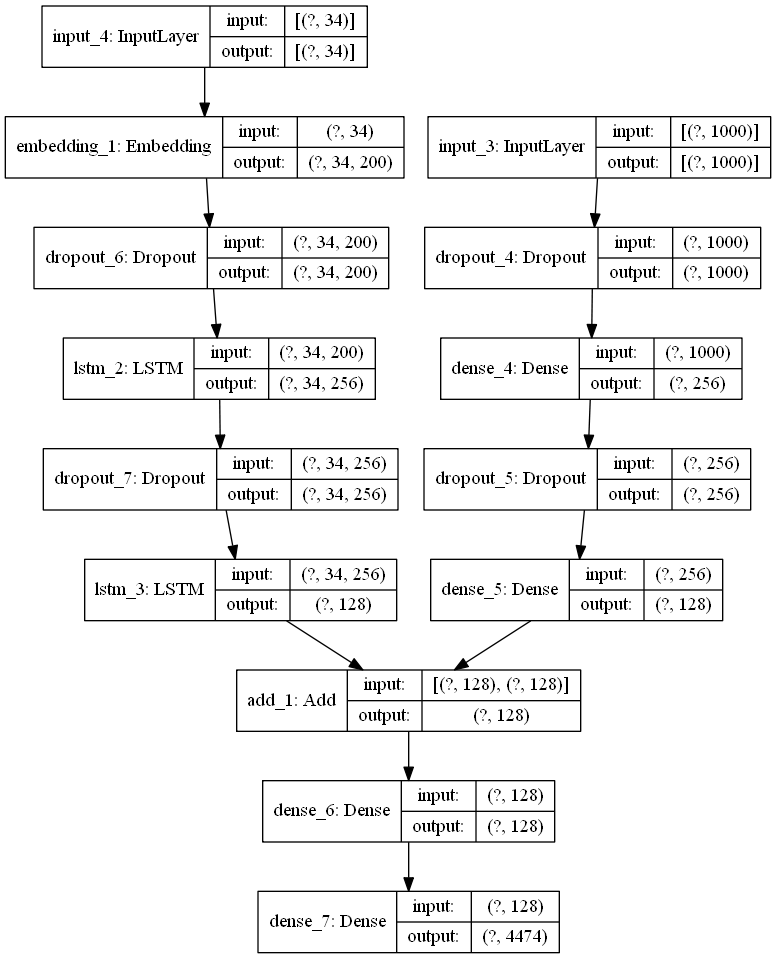

In [57]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
    
# 모델 컴파일
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')
caption_model.summary()
plot_model(caption_model, to_file='model.png', show_shapes=True)

In [58]:
import pickle

# 정리된 설명 load
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict() # 사전 형식
    for line in doc.split('\n'):
        tokens = line.split()
        # 아이디와 설명 구분
        image_id, image_desc = tokens[0], tokens[1:]
        # dataset에 없는 이미지 건너뛰기
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # 토큰에서 설명으로
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # 저장
            descriptions[image_id].append(desc)
    return descriptions

# 사진 특징 불러오기
def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in dataset} # 필터링 된 특징 가져오기
    return features

# 미리 정의된 사진 식별자 목록 불러오는 함수
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # 라인별로 처리
    for line in doc.split('\n'):
        # 비어있는 줄은 넘긴다.
        if len(line) < 1:
            continue
        # 이미지 식별자 get
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset) # 중복없이 구성 

In [59]:
encoding_train = load_photo_features('features.pkl', train) 

In [60]:
len(encoding_train)

6000

In [61]:
number_pics_per_bath = 3
steps = len(train_desc) // number_pics_per_bath

In [62]:
EPOCHS = 50

In [63]:
from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [64]:
# 모델 정의
#model = LSTM_model(vocab_size, max_length)
#steps = len(train_descriptions)
#for i in range(EPOCHS*2):
    # 데이터 생성기 생성
#    generator = data_generator(train_descriptions, train_features, wordtoidx, max_length, number_pics_per_bath)
#    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # 모델 저장
#    model.save('model_' + str(i) + '.h5')

In [71]:
model_path = os.path.join(os.getcwd(),"data",f'20.06.15_caption-model.h5')
if not os.path.exists(model_path):
    for i in tqdm(range(EPOCHS * 2)): 
        generator = data_generator(train_desc, encoding_train, wordtoidx, max_length, number_pics_per_bath)
        caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

    caption_model.optimizer.learning_rate = 1e-4
    number_pics_per_bath = 6
    steps = len(train_desc) // number_pics_per_bath

    for i in range(EPOCHS):
        generator = data_generator(train_desc, encoding_train, wordtoidx, max_length, number_pics_per_bath)
        caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
    caption_model.save(model_path)
   # print(f"\Training took: {hms_string(time()-start)}")
else:
    caption_model.load_weights(model_path)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

2000/2000 [==============================] - 1475s 738ms/step - loss: 3.2742


  1%|▊                                                                            | 1/100 [24:35<40:34:16, 1475.32s/it]

2000/2000 [==============================] - 1473s 737ms/step - loss: 3.2171


  2%|█▌                                                                           | 2/100 [49:08<40:08:47, 1474.77s/it]

2000/2000 [==============================] - 1478s 739ms/step - loss: 3.1976


  3%|██▎                                                                        | 3/100 [1:13:46<39:45:40, 1475.67s/it]

2000/2000 [==============================] - 1485s 742ms/step - loss: 3.1847


  4%|███                                                                        | 4/100 [1:38:31<39:25:23, 1478.37s/it]

2000/2000 [==============================] - 1484s 742ms/step - loss: 3.1730


  5%|███▊                                                                       | 5/100 [2:03:14<39:03:13, 1479.93s/it]

2000/2000 [==============================] - 1489s 744ms/step - loss: 3.1654


  6%|████▌                                                                      | 6/100 [2:28:03<38:42:42, 1482.58s/it]

2000/2000 [==============================] - 1488s 744ms/step - loss: 3.1534


  7%|█████▎                                                                     | 7/100 [2:52:52<38:20:43, 1484.34s/it]

2000/2000 [==============================] - 1490s 745ms/step - loss: 3.1443


  8%|██████                                                                     | 8/100 [3:17:41<37:58:33, 1486.01s/it]

2000/2000 [==============================] - 1489s 744ms/step - loss: 3.1348


  9%|██████▊                                                                    | 9/100 [3:42:30<37:35:03, 1486.86s/it]

2000/2000 [==============================] - 1489s 744ms/step - loss: 3.1307


 10%|███████▍                                                                  | 10/100 [4:07:19<37:11:12, 1487.47s/it]

2000/2000 [==============================] - 1491s 746ms/step - loss: 3.1200


 11%|████████▏                                                                 | 11/100 [4:32:10<36:48:03, 1488.58s/it]

2000/2000 [==============================] - 1488s 744ms/step - loss: 3.1153


 12%|████████▉                                                                 | 12/100 [4:56:58<36:23:00, 1488.42s/it]

2000/2000 [==============================] - 1488s 744ms/step - loss: 3.1071


 13%|█████████▌                                                                | 13/100 [5:21:46<35:57:55, 1488.22s/it]

2000/2000 [==============================] - 1489s 745ms/step - loss: 3.1028


 14%|██████████▎                                                               | 14/100 [5:46:36<35:33:38, 1488.59s/it]

2000/2000 [==============================] - 1492s 746ms/step - loss: 3.0978


 15%|███████████                                                               | 15/100 [6:11:27<35:10:09, 1489.52s/it]

2000/2000 [==============================] - 1491s 746ms/step - loss: 3.0913


 16%|███████████▊                                                              | 16/100 [6:36:18<34:45:59, 1490.00s/it]

2000/2000 [==============================] - 1491s 745ms/step - loss: 3.0873


 17%|████████████▌                                                             | 17/100 [7:01:09<34:21:29, 1490.23s/it]

2000/2000 [==============================] - 1494s 747ms/step - loss: 3.0784


 18%|█████████████▎                                                            | 18/100 [7:26:04<33:58:19, 1491.46s/it]

2000/2000 [==============================] - 1492s 746ms/step - loss: 3.0747


 19%|██████████████                                                            | 19/100 [7:50:55<33:33:41, 1491.62s/it]

2000/2000 [==============================] - 1493s 747ms/step - loss: 3.0710


 20%|██████████████▊                                                           | 20/100 [8:15:49<33:09:27, 1492.09s/it]

2000/2000 [==============================] - 1497s 748ms/step - loss: 3.0641


 21%|███████████████▌                                                          | 21/100 [8:40:45<32:46:24, 1493.47s/it]

2000/2000 [==============================] - 1496s 748ms/step - loss: 3.0609


 22%|████████████████▎                                                         | 22/100 [9:05:41<32:22:26, 1494.19s/it]

2000/2000 [==============================] - 1497s 748ms/step - loss: 3.0555


 23%|█████████████████                                                         | 23/100 [9:30:38<31:58:37, 1495.03s/it]

2000/2000 [==============================] - 1496s 748ms/step - loss: 3.0525


 24%|█████████████████▊                                                        | 24/100 [9:55:35<31:34:15, 1495.47s/it]

2000/2000 [==============================] - 1498s 749ms/step - loss: 3.0454


 25%|██████████████████▎                                                      | 25/100 [10:20:33<31:10:23, 1496.31s/it]

2000/2000 [==============================] - 1497s 748ms/step - loss: 3.0460


 26%|██████████████████▉                                                      | 26/100 [10:45:30<30:45:41, 1496.50s/it]

2000/2000 [==============================] - 1500s 750ms/step - loss: 3.0427


 27%|███████████████████▋                                                     | 27/100 [11:10:30<30:21:56, 1497.49s/it]

2000/2000 [==============================] - 1498s 749ms/step - loss: 3.0412


 28%|████████████████████▍                                                    | 28/100 [11:35:28<29:57:09, 1497.63s/it]

2000/2000 [==============================] - 1495s 747ms/step - loss: 3.0346


 29%|█████████████████████▏                                                   | 29/100 [12:00:23<29:31:15, 1496.84s/it]

2000/2000 [==============================] - 1506s 753ms/step - loss: 3.0329


 30%|█████████████████████▉                                                   | 30/100 [12:25:28<29:09:21, 1499.45s/it]

2000/2000 [==============================] - 1509s 755ms/step - loss: 3.0283


 31%|██████████████████████▋                                                  | 31/100 [12:50:37<28:47:41, 1502.34s/it]

2000/2000 [==============================] - 1500s 750ms/step - loss: 3.0243


 32%|███████████████████████▎                                                 | 32/100 [13:15:37<28:21:49, 1501.61s/it]

2000/2000 [==============================] - 1499s 749ms/step - loss: 3.0219


 33%|████████████████████████                                                 | 33/100 [13:40:36<27:55:55, 1500.83s/it]

2000/2000 [==============================] - 1498s 749ms/step - loss: 3.0198


 34%|████████████████████████▊                                                | 34/100 [14:05:34<27:29:54, 1499.91s/it]

2000/2000 [==============================] - 1499s 749ms/step - loss: 3.0177


 35%|█████████████████████████▌                                               | 35/100 [14:30:33<27:04:28, 1499.52s/it]

2000/2000 [==============================] - 1500s 750ms/step - loss: 3.0130


 36%|██████████████████████████▎                                              | 36/100 [14:55:32<26:39:32, 1499.57s/it]

2000/2000 [==============================] - 1503s 751ms/step - loss: 3.0102


 37%|███████████████████████████                                              | 37/100 [15:20:35<26:15:33, 1500.53s/it]

2000/2000 [==============================] - 1505s 753ms/step - loss: 3.0062


 38%|███████████████████████████▋                                             | 38/100 [15:45:40<25:51:57, 1501.89s/it]

2000/2000 [==============================] - 1506s 753ms/step - loss: 3.0060


 39%|████████████████████████████▍                                            | 39/100 [16:10:46<25:28:03, 1503.02s/it]

2000/2000 [==============================] - 1504s 752ms/step - loss: 3.0032


 40%|█████████████████████████████▏                                           | 40/100 [16:35:50<25:03:15, 1503.25s/it]

2000/2000 [==============================] - 1504s 752ms/step - loss: 3.0017


 41%|█████████████████████████████▉                                           | 41/100 [17:00:54<24:38:26, 1503.49s/it]

2000/2000 [==============================] - 1506s 753ms/step - loss: 2.9996


 42%|██████████████████████████████▋                                          | 42/100 [17:26:00<24:14:15, 1504.40s/it]

2000/2000 [==============================] - 1508s 754ms/step - loss: 2.9985


 43%|███████████████████████████████▍                                         | 43/100 [17:51:08<23:50:13, 1505.51s/it]

2000/2000 [==============================] - 1506s 753ms/step - loss: 2.9949


 44%|████████████████████████████████                                         | 44/100 [18:16:15<23:25:22, 1505.76s/it]

2000/2000 [==============================] - 1504s 752ms/step - loss: 2.9910


 45%|████████████████████████████████▊                                        | 45/100 [18:41:19<22:59:48, 1505.24s/it]

2000/2000 [==============================] - 1503s 752ms/step - loss: 2.9923


 46%|█████████████████████████████████▌                                       | 46/100 [19:06:22<22:34:08, 1504.61s/it]

2000/2000 [==============================] - 1504s 752ms/step - loss: 2.9912


 47%|██████████████████████████████████▎                                      | 47/100 [19:31:26<22:08:56, 1504.46s/it]

2000/2000 [==============================] - 1503s 751ms/step - loss: 2.9873


 48%|███████████████████████████████████                                      | 48/100 [19:56:29<21:43:28, 1504.02s/it]

2000/2000 [==============================] - 1505s 753ms/step - loss: 2.9835


 49%|███████████████████████████████████▊                                     | 49/100 [20:21:34<21:18:40, 1504.32s/it]

2000/2000 [==============================] - 1507s 754ms/step - loss: 2.9815


 50%|████████████████████████████████████▌                                    | 50/100 [20:46:41<20:54:21, 1505.22s/it]

2000/2000 [==============================] - 1506s 753ms/step - loss: 2.9786


 51%|█████████████████████████████████████▏                                   | 51/100 [21:11:47<20:29:28, 1505.48s/it]

2000/2000 [==============================] - 1504s 752ms/step - loss: 2.9783


 52%|█████████████████████████████████████▉                                   | 52/100 [21:36:51<20:03:57, 1504.95s/it]

2000/2000 [==============================] - 1503s 751ms/step - loss: 2.9786


 53%|██████████████████████████████████████▋                                  | 53/100 [22:01:54<19:38:23, 1504.33s/it]

2000/2000 [==============================] - 1507s 753ms/step - loss: 2.9782


 54%|███████████████████████████████████████▍                                 | 54/100 [22:27:01<19:13:53, 1505.07s/it]

2000/2000 [==============================] - 1504s 752ms/step - loss: 2.9727


 55%|████████████████████████████████████████▏                                | 55/100 [22:52:04<18:48:29, 1504.65s/it]

2000/2000 [==============================] - 1507s 754ms/step - loss: 2.9707


 56%|████████████████████████████████████████▉                                | 56/100 [23:17:11<18:23:57, 1505.39s/it]

2000/2000 [==============================] - 1508s 754ms/step - loss: 2.9725


 57%|█████████████████████████████████████████▌                               | 57/100 [23:42:19<17:59:23, 1506.14s/it]

2000/2000 [==============================] - 1501s 751ms/step - loss: 2.9704


 58%|██████████████████████████████████████████▎                              | 58/100 [24:07:20<17:33:14, 1504.63s/it]

2000/2000 [==============================] - 1502s 751ms/step - loss: 2.9664


 59%|███████████████████████████████████████████                              | 59/100 [24:32:23<17:07:41, 1503.95s/it]

2000/2000 [==============================] - 1502s 751ms/step - loss: 2.9629


 60%|███████████████████████████████████████████▊                             | 60/100 [24:57:25<16:42:19, 1503.49s/it]

2000/2000 [==============================] - 1508s 754ms/step - loss: 2.9645


 61%|████████████████████████████████████████████▌                            | 61/100 [25:22:33<16:18:03, 1504.71s/it]

2000/2000 [==============================] - 1509s 755ms/step - loss: 2.9628


 62%|█████████████████████████████████████████████▎                           | 62/100 [25:47:42<15:53:51, 1506.10s/it]

2000/2000 [==============================] - 1505s 753ms/step - loss: 2.9619


 63%|█████████████████████████████████████████████▉                           | 63/100 [26:12:47<15:28:35, 1505.83s/it]

2000/2000 [==============================] - 1503s 751ms/step - loss: 2.9581


 64%|██████████████████████████████████████████████▋                          | 64/100 [26:37:50<15:02:59, 1504.97s/it]

2000/2000 [==============================] - 1504s 752ms/step - loss: 2.9589


 65%|███████████████████████████████████████████████▍                         | 65/100 [27:02:55<14:37:46, 1504.75s/it]

2000/2000 [==============================] - 1508s 754ms/step - loss: 2.9563


 66%|████████████████████████████████████████████████▏                        | 66/100 [27:28:03<14:13:15, 1505.76s/it]

2000/2000 [==============================] - 1506s 753ms/step - loss: 2.9596


 67%|████████████████████████████████████████████████▉                        | 67/100 [27:53:09<13:48:17, 1505.97s/it]

2000/2000 [==============================] - 1505s 753ms/step - loss: 2.9544


 68%|█████████████████████████████████████████████████▋                       | 68/100 [28:18:15<13:23:06, 1505.82s/it]

2000/2000 [==============================] - 1505s 752ms/step - loss: 2.9541


 69%|██████████████████████████████████████████████████▎                      | 69/100 [28:43:19<12:57:49, 1505.48s/it]

2000/2000 [==============================] - 1504s 752ms/step - loss: 2.9544


 70%|███████████████████████████████████████████████████                      | 70/100 [29:08:23<12:32:31, 1505.04s/it]

2000/2000 [==============================] - 1504s 752ms/step - loss: 2.9520


 71%|███████████████████████████████████████████████████▊                     | 71/100 [29:33:27<12:07:17, 1504.75s/it]

2000/2000 [==============================] - 1505s 752ms/step - loss: 2.9481


 72%|████████████████████████████████████████████████████▌                    | 72/100 [29:58:32<11:42:11, 1504.70s/it]

2000/2000 [==============================] - 1506s 753ms/step - loss: 2.9496


 73%|█████████████████████████████████████████████████████▎                   | 73/100 [30:23:38<11:17:16, 1505.07s/it]

2000/2000 [==============================] - 1506s 753ms/step - loss: 2.9473


 74%|██████████████████████████████████████████████████████                   | 74/100 [30:48:44<10:52:17, 1505.28s/it]

2000/2000 [==============================] - 1506s 753ms/step - loss: 2.9437


 75%|██████████████████████████████████████████████████████▊                  | 75/100 [31:13:50<10:27:19, 1505.60s/it]

2000/2000 [==============================] - 1505s 752ms/step - loss: 2.9453


 76%|███████████████████████████████████████████████████████▍                 | 76/100 [31:38:55<10:02:09, 1505.41s/it]

2000/2000 [==============================] - 1506s 753ms/step - loss: 2.9419


 77%|████████████████████████████████████████████████████████▉                 | 77/100 [32:04:01<9:37:08, 1505.57s/it]

2000/2000 [==============================] - 1506s 753ms/step - loss: 2.9434


 78%|█████████████████████████████████████████████████████████▋                | 78/100 [32:29:07<9:12:07, 1505.81s/it]

2000/2000 [==============================] - 1509s 755ms/step - loss: 2.9410


 79%|██████████████████████████████████████████████████████████▍               | 79/100 [32:54:17<8:47:24, 1506.86s/it]

2000/2000 [==============================] - 1508s 754ms/step - loss: 2.9366


 80%|███████████████████████████████████████████████████████████▏              | 80/100 [33:19:25<8:22:23, 1507.19s/it]

2000/2000 [==============================] - 1509s 755ms/step - loss: 2.9392


 81%|███████████████████████████████████████████████████████████▉              | 81/100 [33:44:34<7:57:26, 1507.74s/it]

2000/2000 [==============================] - 1507s 754ms/step - loss: 2.9391


 82%|████████████████████████████████████████████████████████████▋             | 82/100 [34:09:41<7:32:15, 1507.55s/it]

2000/2000 [==============================] - 1507s 753ms/step - loss: 2.9363


 83%|█████████████████████████████████████████████████████████████▍            | 83/100 [34:34:47<7:07:03, 1507.24s/it]

2000/2000 [==============================] - 1505s 752ms/step - loss: 2.9357


 84%|██████████████████████████████████████████████████████████████▏           | 84/100 [34:59:52<6:41:43, 1506.48s/it]

2000/2000 [==============================] - 1517s 758ms/step - loss: 2.9352


 85%|██████████████████████████████████████████████████████████████▉           | 85/100 [35:25:08<6:17:22, 1509.51s/it]

2000/2000 [==============================] - 1509s 754ms/step - loss: 2.9337


 86%|███████████████████████████████████████████████████████████████▋          | 86/100 [35:50:17<5:52:10, 1509.33s/it]

2000/2000 [==============================] - 1479s 740ms/step - loss: 2.9317


 87%|████████████████████████████████████████████████████████████████▍         | 87/100 [36:14:57<5:25:03, 1500.30s/it]

2000/2000 [==============================] - 1512s 756ms/step - loss: 2.9312


 88%|█████████████████████████████████████████████████████████████████         | 88/100 [36:40:09<5:00:46, 1503.91s/it]

2000/2000 [==============================] - 1725s 863ms/step - loss: 2.9325


 89%|█████████████████████████████████████████████████████████████████▊        | 89/100 [37:08:54<4:47:52, 1570.26s/it]

2000/2000 [==============================] - 1546s 773ms/step - loss: 2.9302


 90%|██████████████████████████████████████████████████████████████████▌       | 90/100 [37:34:40<4:20:30, 1563.05s/it]

2000/2000 [==============================] - 1655s 827ms/step - loss: 2.9310


 91%|███████████████████████████████████████████████████████████████████▎      | 91/100 [38:02:15<3:58:35, 1590.63s/it]

2000/2000 [==============================] - 1625s 812ms/step - loss: 2.9294


 92%|████████████████████████████████████████████████████████████████████      | 92/100 [38:29:20<3:33:27, 1600.90s/it]

2000/2000 [==============================] - 1773s 887ms/step - loss: 2.9295


 93%|████████████████████████████████████████████████████████████████████▊     | 93/100 [38:58:53<3:12:48, 1652.61s/it]

2000/2000 [==============================] - 1871s 936ms/step - loss: 2.9259


 94%|█████████████████████████████████████████████████████████████████████▌    | 94/100 [39:30:04<2:51:48, 1718.13s/it]

2000/2000 [==============================] - 1862s 931ms/step - loss: 2.9298


 95%|██████████████████████████████████████████████████████████████████████▎   | 95/100 [40:01:06<2:26:45, 1761.18s/it]

2000/2000 [==============================] - 1795s 897ms/step - loss: 2.9266


 96%|███████████████████████████████████████████████████████████████████████   | 96/100 [40:31:01<1:58:04, 1771.20s/it]

2000/2000 [==============================] - 1836s 918ms/step - loss: 2.9257


 97%|███████████████████████████████████████████████████████████████████████▊  | 97/100 [41:01:37<1:29:32, 1790.73s/it]

2000/2000 [==============================] - 1596s 798ms/step - loss: 2.9210


 98%|██████████████████████████████████████████████████████████████████████████▍ | 98/100 [41:28:13<57:44, 1732.31s/it]

2000/2000 [==============================] - 1617s 809ms/step - loss: 2.9239


 99%|███████████████████████████████████████████████████████████████████████████▏| 99/100 [41:55:10<28:17, 1697.80s/it]

2000/2000 [==============================] - 1579s 790ms/step - loss: 2.9226


100%|███████████████████████████████████████████████████████████████████████████| 100/100 [42:21:30<00:00, 1524.90s/it]


1000/1000 [==============================] - 1263s 1s/step - loss: 2.9267


In [72]:
import time
time.strftime('%c', time.localtime(time.time()))

'Mon Jun 15 16:30:07 2020'

In [67]:
def real_extract_features(filename):

    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1000, activation='softmax'))
    
    # load Image
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image) # numpy array로 변환
    image = np.expand_dims(image, axis=0)
        
    # 특징 추출
    feature = model.predict(image, verbose=0)
    feature = np.reshape(feature, OUTPUT_DIM )
        
    return feature

def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

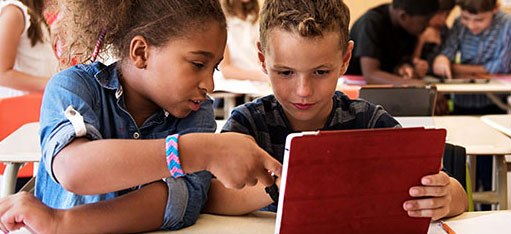

two dogs are playing in the snow


In [70]:
from IPython.display import display, Image
# 적용하고싶은 이미지 load
file = '14.jpeg'
photo = real_extract_features(file)
photo = photo.reshape((1,OUTPUT_DIM))

# 설명 생성
description = generateCaption(photo)
display(Image(filename = file))
print(description)

In [ ]:
# 모델 평가
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        # 설명 생성
        photo = photos[key].reshape((1,OUTPUT_DIM))
        yhat = generateCaption(photo)
        # 실제와 예측 값 저장
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # BLEU 점수 계산
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
# 학습 데이터 set 토큰 준비

# 학습데이터셋 로드
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

# 설명
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

# 토큰화 준비
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# 문장 최고길이 
print('Description Length: %d' % max_length)

# 테스트 데이터셋

# 테스트 데이터셋 로드
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

# 설명
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

# 사진 특징
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))


# 평가 모델
evaluate_model(caption_model, test_descriptions, test_features, tokenizer, max_length)

# 필요한 부분만

In [1]:
from pickle import load
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
import numpy as np
import os
from tqdm import tqdm
import string
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from IPython.display import display, Image

Using TensorFlow backend.


In [2]:
# 캡셔닝 모델 생성
def LSTM_model(vocab_size, max_length):
    inputs1 = Input(shape=(1000,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    fe3 = Dropout(0.5)(fe2)
    fe4 = Dense(128, activation = 'relu')(fe3)
    
    # 시퀀스 모델
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2) 
    #mask_zero=True : 0으로 패딩된 값을 마스킹하여 네트워크의 뒤로 전달되지 않게 만든다.
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, return_sequences=True)(se2)
    se4 = Dropout(0.5)(se3)
    se5 = LSTM(128, return_sequences= False)(se4)
    
    # 디코더
    decoder1 = add([fe4, se5])
    decoder2 = Dense(128, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # [image, seq] [word]로 묶기
    caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    #caption_model.summary()
    return caption_model


def real_extract_features(filename):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1000, activation='softmax'))

    # load Image
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)  # numpy array로 변환
    image = np.expand_dims(image, axis=0)

    # 특징 추출
    feature = model.predict(image, verbose=0)
    feature = np.reshape(feature, OUTPUT_DIM)

    return feature


def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [3]:
OUTPUT_DIM = 1000
embedding_dim = 200
max_length = 34

START = "startseq"
STOP = "endseq"

wordtoidx = load(open('wti.pkl', 'rb'))
idxtoword = load(open('itw.pkl', 'rb'))

vocab_size = len(idxtoword) + 1 

embedding_matrix = np.loadtxt('embedded.txt')
embeddings_index = load(open('ebd_i.pkl', 'rb'))

for word, i in wordtoidx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

caption_model = LSTM_model(vocab_size, max_length)
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
    
# 모델 컴파일
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

model_path = os.path.join(os.getcwd(),f'caption-model.h5')
caption_model.load_weights(model_path)

file = 'img.jpg'
photo = real_extract_features(file)
photo = photo.reshape((1, OUTPUT_DIM))

        # 설명 생성
description = generateCaption(photo)
print(description)

two dogs are playing in the snow
